In [70]:
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import seaborn as sns

from scipy import stats



import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

import env
import os

pd.set_option('display.max_columns', None)

# 1.Select a dataset with a continuous target variable.

In [71]:
# function to establish connection to MySQL workbench to retrieve data.
def get_connection(db, user=env.username, host=env.host, password=env.password):
    return f'mysql+pymysql://{env.username}:{env.password}@{env.host}/{db}'

In [72]:
def new_zillow_data():
    sql_querry= '''
            select parcelid as property_id, 
            bathroomcnt as bath, 
            bedroomcnt as bed, 
            calculatedfinishedsquarefeet as sq_ft_area, 
            yearbuilt, 
            taxvaluedollarcnt as home_estimate,
            fips as county_code, 
            from properties_2017
            join predictions_2017 as pred using(parcelid)
            join propertylandusetype as prop using (propertylandusetypeid)
            where (pred.transactiondate like"2017-%%" AND prop.propertylandusedesc = "Single Family Residential")
            '''
    
    
    df= pd.read_sql(sql_querry, get_connection('zillow'))
    
    return df

    

In [5]:
def zillow_data():
    '''this function returns the zillow data and creates the csv file in local directory  if it doesnot exist already.'''
    filename= "zillow.csv"
    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        # read data from database in dataframe
        df= new_zillow_data()
        #cache data
        df.to_csv(filename)
        return df



In [6]:
df=zillow_data()
df.head()

,property_id,bath,bed,sq_ft_area,yearbuilt,home_estimate,county_code,tax_paid
0,14372057,2.5,2,1348,1979,343967,6059,3628.14
1,13929199,2.0,3,1221,1955,367034,6059,4589.60
2,12430095,2.0,3,1462,1950,79713,6037,1269.65
3,13033318,1.0,2,768,1926,270458,6037,3373.09
4,12079615,4.0,4,3696,1989,940251,6037,10313.18


In [ ]:
df.isna().sum()

In [7]:
df.shape

(52441, 8)

In [6]:
df1= df.copy()

#  after dropping all the null values, we still have 99% of our data 
#handle null values by dropping
df1.dropna().shape[0]/df1.shape[0]

1.0

In [7]:

df= df.dropna()



In [8]:
#handling outliers

# only considering properties with bath count <= 6, bedroom count of<=6 and home estimate less than2.5 million

df= df[df.bath <= 6]
df= df[df.bed <= 6]
df= df[df.home_estimate <= 25_00_000]

In [9]:
df.shape

(51261, 8)

In [ ]:
df.info()

In [ ]:
df[['bed','yearbuilt','county_code']]=df[['bed','yearbuilt','county_code']].astype(int)

In [ ]:
df.info()

In [ ]:
df.isna().any()

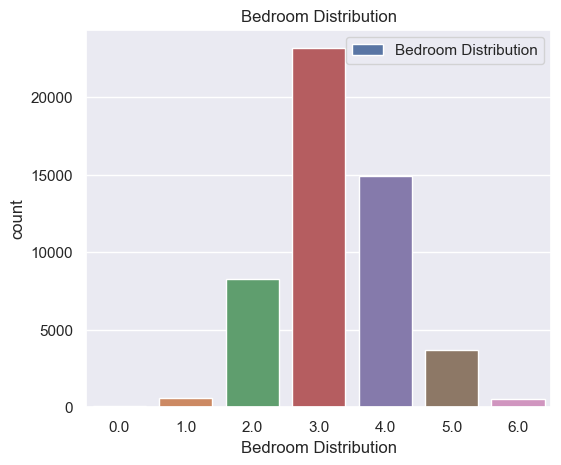

In [21]:
plt.figure(figsize = (6,5), dpi=100,facecolor = "w")
sns.countplot(df['bed'], label = "Bedroom Distribution")
sns.set(style="darkgrid")
plt.legend()

plt.title("Bedroom Distribution")
plt.xlabel('Bedroom Distribution')
plt.show()

In [10]:
#splitting data into train, validate and test sample
train_and_validate, test = train_test_split(df,test_size=.2 ,random_state=123)
train, validate = train_test_split(train_and_validate,test_size=.3,random_state=123)
print(train.shape, validate.shape, test.shape)

(28705, 8) (12303, 8) (10253, 8)


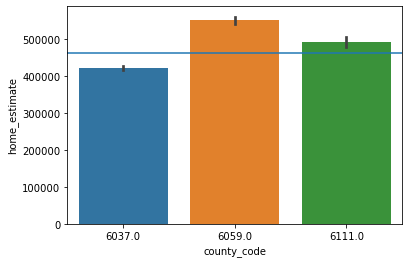

In [13]:
avg_home_value = train.home_estimate.mean()
sns.barplot(x='county_code',y='home_estimate', data= train)
plt.axhline(avg_home_value)
plt.show()


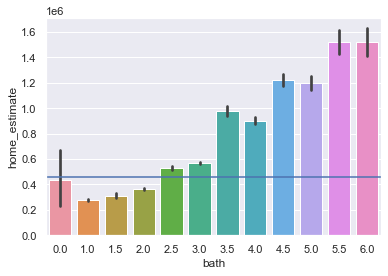

In [31]:
sns.barplot(data =train, x='bath',y='home_estimate')
avg_home_value = train.home_estimate.mean()
plt.axhline(avg_home_value)
plt.show()

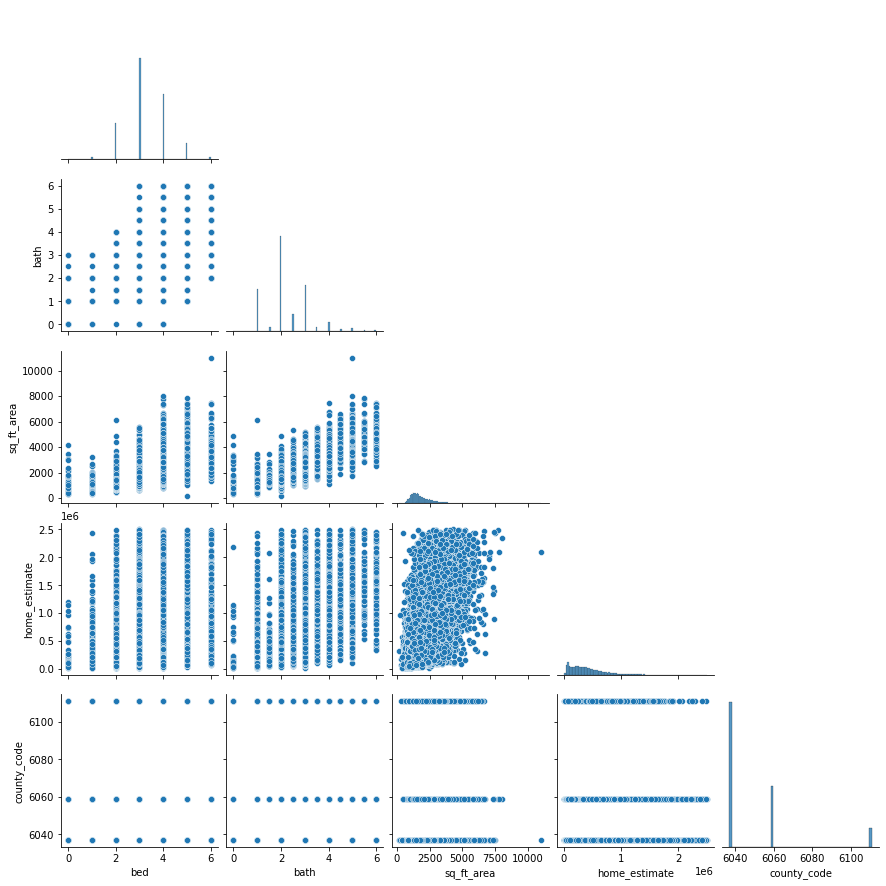

In [24]:
sns.pairplot(train[['bed','bath','sq_ft_area','home_estimate','county_code']], corner= True)
plt.show()

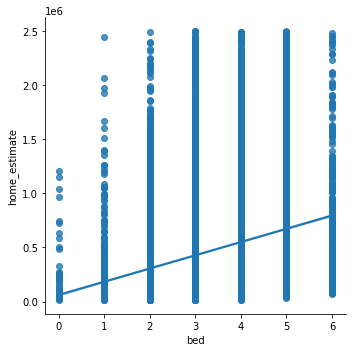

In [23]:
sns.lmplot(x='bed',y='home_estimate', data= train)

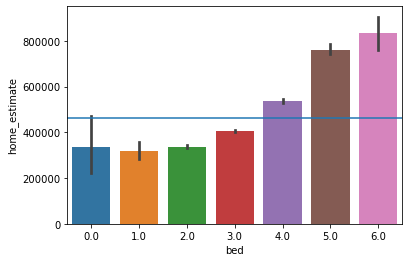

In [12]:
sns.barplot(data =train, x='bed',y='home_estimate')
avg_home_value = train.home_estimate.mean()
plt.axhline(avg_home_value)
plt.show()

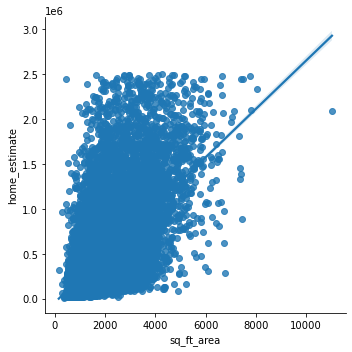

In [25]:
sns.lmplot( data= train, x='sq_ft_area',y='home_estimate')


# Statistical testing
α = 0.05

In [36]:
corr, p = stats.pearsonr(train['sq_ft_area'], train['home_estimate'])
r,p

(0.5870632183798623, 0.0)

In [41]:
corr,p = stats.pearsonr(train['bed'], train['home_estimate'])
corr, p

(0.280579142381874, 0.0)

In [42]:
corr,p = stats.pearsonr(train['bath'], train['home_estimate'])
corr, p

(0.5165262145078136, 0.0)

In [ ]:
scipy.stats.f_oneway()

since p < α in all cases there is correlation between them and the property value.b

In [ ]:
α= 0.05
# Use correlation testing(pearsonr).
corr, p = stats.pearsonr(train.tenure, train.monthly_charges)

if p < α:
    print("We reject the null hypothesis.\nBoth variables are linearly correlated")
else:
    print("We fail to reject the null hypothesis")
    
corr, p

In [44]:
train.head()


,property_id,bath,bed,sq_ft_area,yearbuilt,home_estimate,county_code,tax_paid
20186,14238931,2.0,4,1706,1961,70681,6059,1003.84
29090,13884632,2.0,2,1311,1920,38968,6059,748.44
1939,11032145,1.0,3,1014,1949,60642,6037,824.24
37028,12159594,2.0,3,1648,1915,339718,6037,4186.32
13693,12060666,2.0,3,1319,1925,241427,6037,2721.25


In [60]:
#dummy columns for categorical column county_code
train_dummy = pd.get_dummies(columns=['county_code'],data= train,drop_first= True)
train_dummy.head()

,property_id,bath,bed,sq_ft_area,yearbuilt,home_estimate,tax_paid,county_code_6059,county_code_6111
20186,14238931,2.0,4,1706,1961,70681,1003.84,1,0
29090,13884632,2.0,2,1311,1920,38968,748.44,1,0
1939,11032145,1.0,3,1014,1949,60642,824.24,0,0
37028,12159594,2.0,3,1648,1915,339718,4186.32,0,0
13693,12060666,2.0,3,1319,1925,241427,2721.25,0,0


In [61]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

###  need to scale the data  for sq_ft_area and home_estimate and make dummy variables for county_code

In [62]:
train_X = train_dummy.drop(columns=['property_id','yearbuilt','tax_paid','home_estimate'])
train_y = train_dummy['home_estimate']                          

In [63]:
# kbest for feature selection
f_selector = SelectKBest(f_regression, k=3)

f_selector.fit(train_X, train_y)

feature_mask = f_selector.get_support()
feature_mask

array([ True,  True,  True, False, False])

In [64]:
train_X.columns[feature_mask]

Index(['bath', 'bed', 'sq_ft_area'], dtype='object')

In [65]:
#features to be selected are bath, bed and sq_ft_area

In [58]:
X_train= train[['bath','bed','sq_ft_area']]
y_train= train['home_estimate']

In [59]:
X_train.head()

,bath,bed,sq_ft_area
20186,2.0,4,1706
29090,2.0,2,1311
1939,1.0,3,1014
37028,2.0,3,1648
13693,2.0,3,1319


In [83]:
X_train = train[['bed','bath','sq_ft_area']]
y_train= train['home_estimate']

X_validate = validate[['bed','bath','sq_ft_area']]
y_validate = validate['home_estimate']


X_test = test[['bed','bath','sq_ft_area']]
y_test = test['home_estimate']

In [84]:
y_train=  pd.DataFrame(y_train)
y_validate= pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
y_validate.head()

,home_estimate
9128,310227
49509,717541
4981,407932
47601,440101
11317,508000


In [95]:
# setting the baseline to the mean of target variable
baseline = round(train.home_estimate.mean(),2)
baseline


from sklearn.metrics import mean_squared_error
from math import sqrt

#Establish baselines for the train and validation subsets
baseline = round(train.home_estimate.mean(),2)

train['baseline'] = baseline
validate['baseline'] = baseline

train_rmse = sqrt(mean_squared_error(train.home_estimate, train.baseline))
valid_rmse = sqrt(mean_squared_error(validate.home_estimate, validate.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(valid_rmse))

Train baseline RMSE: 392237.61472689814.
Validation baseline RMSE: 389304.0292739811.


In [85]:
#import sklearn.preprocessing library
import sklearn.preprocessing

# scale the data by using MinMaxScaler
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit the scaler
scaler.fit(X_train)

# Use the scaler to transform train, validate,test
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [86]:
# cahnging the scaled samples back to dataframe.
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns= X_train.columns)
X_validate_scaled_df = pd.DataFrame(X_validate_scaled, columns= X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns= X_train.columns)

In [87]:
X_train_scaled_df.head()

,bed,bath,sq_ft_area
0,0.666667,0.333333,0.142989
1,0.333333,0.333333,0.106643
2,0.500000,0.166667,0.079315
3,0.500000,0.333333,0.137652
4,0.500000,0.333333,0.107379


# Modeling

In [88]:
# import libraries for the regression modelling from sklearn.
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor


# 1.fit the data using linear regression model
lm = LinearRegression()

# fit the data
lm.fit(X_train_scaled_df, y_train)

LinearRegression()

In [89]:
# 2. modeling using lars and fit the data
lars = LassoLars(alpha=1.0)

lars.fit(X_train_scaled_df, y_train)

LassoLars()

In [90]:
#3. #Instantiate TweedieRegressor and fit
glm = TweedieRegressor(power=0, alpha=1)

glm.fit(X_train_scaled_df, y_train)

TweedieRegressor(alpha=1, power=0)

In [93]:
from sklearn.metrics import mean_squared_error
from math import sqrt
#Create a looping statement to evaluate all models
models = [lm, lars, glm]

for model in models:
    y_train[str(model)] = model.predict(X_train_scaled_df)
    rmse_train = sqrt(mean_squared_error(y_train.home_estimate, y_train[str(model)]))
                                         
    
    y_validate[str(model)] = model.predict(X_validate_scaled_df)
    rmse_valid = sqrt(mean_squared_error(y_validate.home_estimate, y_validate[str(model)]))
                                         
    
    print('RMSE for {} model on the train dataset: {}.'.format(model, round(rmse_train, 2)))
    print('RMSE for {} model on the validate dataset: {}.'.format(model, round(rmse_valid, 2)))
    print()

RMSE for LinearRegression() model on the train dataset: 312788.33.
RMSE for LinearRegression() model on the validate dataset: 313855.22.

RMSE for LassoLars() model on the train dataset: 312788.61.
RMSE for LassoLars() model on the validate dataset: 313859.82.

RMSE for TweedieRegressor(alpha=1, power=0) model on the train dataset: 388469.76.
RMSE for TweedieRegressor(alpha=1, power=0) model on the validate dataset: 385750.35.



In [99]:
#Rename my columns so they're easier to access
y_validate.rename(columns={'LinearRegression()': 'lm', 'LassoLars()': 'lars',
                        'TweedieRegressor(alpha=1, power=0)': 'glm'}, inplace=True)



In [100]:
y_validate.columns

Index(['home_estimate', 'lm', 'lars', 'glm'], dtype='object')

Text(0.5, 1.0, 'Actual estimate vs predicted across all models')

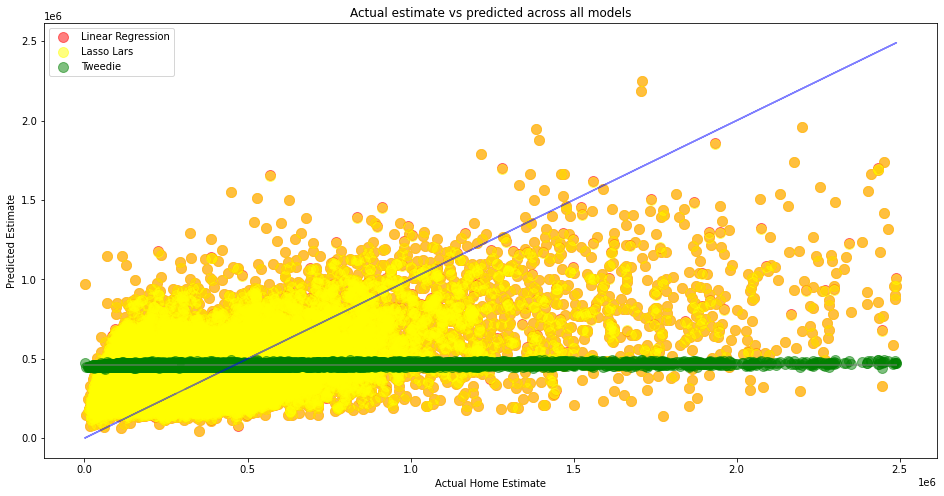

In [107]:
#Plot the predicted home value against the actual home value, with baseline
plt.figure(figsize=(16,8))

plt.plot(y_validate.home_estimate, validate['baseline'], alpha=0.5,
         color='gray', label='_nolegend_')
plt.plot(validate.home_estimate, validate['home_estimate'], alpha=0.5,
         color='blue', label='_nolegend_')

plt.scatter(y_validate.home_estimate, y_validate['lm'], alpha=0.5,
            color='red', s=100, label='Linear Regression')
plt.scatter(y_validate.home_estimate, y_validate['lars'], alpha=0.5,
            color='yellow', s=100, label='Lasso Lars')
plt.scatter(validate.home_estimate, y_validate['glm'], alpha=0.5,
            color='green', s=100, label='Tweedie')

plt.legend()
plt.xlabel('Actual Home Estimate')
plt.ylabel('Predicted Estimate')
plt.title('Actual estimate vs predicted across all models')

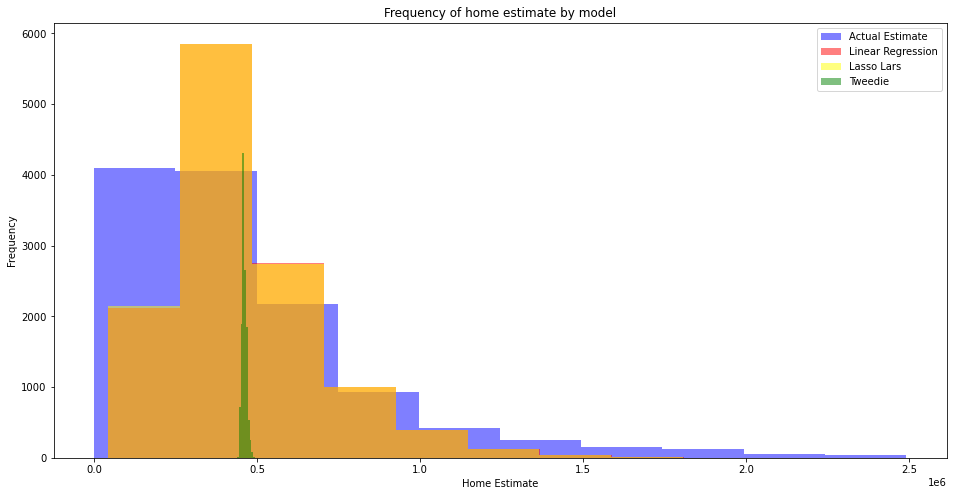

In [102]:
#Distribution of my models' predictions
plt.figure(figsize=(16,8))

plt.hist(y_validate['home_estimate'], color='blue', alpha=0.5, label='Actual Estimate')
plt.hist(y_validate['lm'], color='red', alpha=0.5, label='Linear Regression')
plt.hist(y_validate['lars'], color='yellow', alpha=0.5, label='Lasso Lars')
plt.hist(y_validate['glm'], color='green', alpha=0.5, label='Tweedie')

plt.xlabel('Home Estimate')
plt.ylabel('Frequency')
plt.title('Frequency of home estimate by model')
plt.legend()

In [120]:
# Evaluating the best performing model on test data
y_test['lm'] = lm.predict(X_test_scaled_df)

rmse_test = sqrt(mean_squared_error(y_test['home_estimate'], y_test['lm']))

print(f'RMSE for OLS model on the test dataset: ',round(rmse_test))

RMSE for OLS model on the test dataset:  305935
